In [357]:
# !pip install numpy==1.21.5
## !conda install -c conda-forge rdkit deepchem==2.6.1
#!pip install --pre deepchem

In [384]:
#import modules
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

import pandas as pd
import numpy as np
from rdkit import Chem
import deepchem as dc
import scipy

In [386]:
# #read data as pandas dataframes
# train_df = pd.read_hdf("../data/Microsomal_Clearance.train.scaffold.hdf")
# valid_df = pd.read_hdf("../data/Microsomal_Clearance.valid.scaffold.hdf")
# test_df = pd.read_hdf("../data/Microsomal_Clearance.test.scaffold.hdf")
# # train_df.info(), valid_df.info(), test_df.info()

# #convert dataframes to csv
# infile_name = "train_scaffold.csv"
# train_df.to_csv(infile_name,index=False)

# infile_name = "valid_scaffold.csv"
# valid_df.to_csv(infile_name,index=False)

# infile_name = "test_scaffold.csv"
# test_df.to_csv(infile_name,index=False)

#### Molecular Featurization

In [387]:
#preparing dataset for GraphConvModel
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=['Microsomal Clearance'],
                           feature_field="SMILES",
                           featurizer=featurizer)

train_dataset = loader.featurize("train_scaffold.csv")
valid_dataset = loader.featurize("valid_scaffold.csv")
test_dataset = loader.featurize("test_scaffold.csv")

#normalizing the data with mean zero and standarad deviation 1
transformers = [dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset)]
for dataset in [train_dataset, valid_dataset, test_dataset]:
    for transformer in transformers:
        dataset = transformer.transform(dataset)
#train_dataset, valid_dataset, test_dataset                          

#### Training the GraphConvModel model

In [391]:
model = dc.models.GraphConvModel(n_tasks=1,batch_size=100,mode='regression', 
                                 graph_conv_layers=[128,128],
                                 dense_layer=1000,dropout=0.2)
#n_task is 1 since we have one output value(Microsomal Clearance)
#mode is regression 
#dropout rate is 0.2 to reduce overfitting

#model = dc.models.GraphConvModel(n_tasks=1,batch_size=100,mode='regression', dropout=0.2)
#model.fit(train_dataset, nb_epoch=200)

#storing the loss to visualize it
num_epochs=100
losses=[]
for i in range(num_epochs):
    loss = model.fit(train_dataset, nb_epoch=1)
    #print(f'Epoch {i} loss: {loss}')
    losses.append(loss)


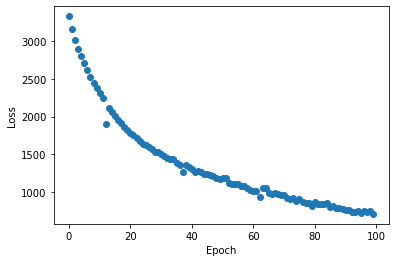

In [392]:
import matplotlib.pyplot as plt
plt.ylabel("Loss")
plt.xlabel("Epoch")
x = range(num_epochs)
y = losses
plt.scatter(x,y)
plt.show()

In [393]:
#using pearson correlation coefficient and r2score as our evaluation metric
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
metric1 = dc.metrics.Metric(dc.metrics.r2_score)
print(model.evaluate(train_dataset, [metric, metric1], transformers=transformers))
print(model.evaluate(valid_dataset, [metric, metric1], transformers=transformers))
print(model.evaluate(test_dataset, [metric, metric1], transformers=transformers))

{'pearson_r2_score': 0.7368201242740712, 'r2_score': 0.6490670165911284}
{'pearson_r2_score': 0.14356613100767981, 'r2_score': 0.0010523121685406256}
{'pearson_r2_score': 0.22091398720018007, 'r2_score': 0.11545339105332098}


In [411]:
#spearman correlation
predicted_test = model.predict(test_dataset)
measured_test = test_dataset.y

scipy.stats.spearmanr(measured_test, predicted_test)

SpearmanrResult(correlation=0.5738861431091611, pvalue=9.33510752665027e-21)

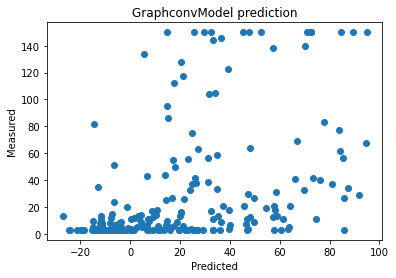

In [412]:
plt.scatter(predicted_test, measured_test)
plt.xlabel('Predicted')
plt.ylabel('Measured')
plt.title(r'GraphconvModel prediction')
plt.show()

#### Optimizing the GraphConvModel model (Hyperparameter tuning)

In [404]:
params_dict ={
    "n_tasks":[1],
    "graph_conv_layers":[[64,64],[128,128],[256,256]],
    "dense_layer_size":[64,128,256],
    "dropout":[0.0,0.20,0.50],
    "mode":['regression']}

optimizer = dc.hyper.GridHyperparamOpt(dc.models.GraphConvModel)

metric = dc.metrics.Metric(dc.metrics.r2_score)

best_model, best_hyperparams, all_results = optimizer.hyperparam_search(
params_dict, train_dataset, valid_dataset, metric, transformers)

In [409]:
best_hyperparams#, all_results

{'n_tasks': 1,
 'graph_conv_layers': [256, 256],
 'dense_layer_size': 256,
 'dropout': 0.0,
 'mode': 'regression'}

In [406]:
#using pearson correlation coefficient and r2score as our evaluation metric
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
metric1 = dc.metrics.Metric(dc.metrics.r2_score)
print(best_model.evaluate(train_dataset, [metric, metric1], transformers=transformers))
print(best_model.evaluate(valid_dataset, [metric, metric1], transformers=transformers))
print(best_model.evaluate(test_dataset, [metric, metric1], transformers=transformers))

{'pearson_r2_score': 0.21859368468845844, 'r2_score': 0.022143574923939036}
{'pearson_r2_score': 0.07586992557911201, 'r2_score': 0.04518631440817211}
{'pearson_r2_score': 0.22194652521456196, 'r2_score': 0.07293694249112714}


In [407]:
#spearman correlation
predicted_test = best_model.predict(test_dataset)
measured_test = test_dataset.y

scipy.stats.spearmanr(measured_test, predicted_test)

SpearmanrResult(correlation=0.5273243475492632, pvalue=3.230959457343423e-17)

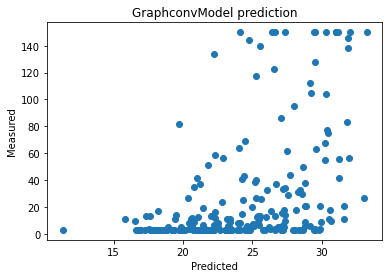

In [410]:
plt.scatter(predicted_test, measured_test)
plt.xlabel('Predicted')
plt.ylabel('Measured')
plt.title(r'GraphconvModel prediction')
plt.show()